# Homework 3

**Name:** -- Agustin Villarreal --

**e-mail:** -- agustin.villarreal0743@alumnos.udg.mx --

# MODULES

In [25]:
# Import necessary libraries
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import random
import os
from plotly.subplots import make_subplots

# Activity 1: Path Length Comparison - Brownian Motion vs Correlated Random Walk

In this activity, we'll compare the path lengths of different types of random walks:
Brownian Motion (BM) and Correlated Random Walk (CRW). We'll generate trajectories 
for each type of movement, calculate their path lengths, and visualize the results.


In [13]:
class Vector2D:
    """A two-dimensional vector class with operations for trajectory generation."""
    
    def __init__(self, x, y=None):
        """Initialize a 2D vector from coordinates or an iterable."""
        if y is None and hasattr(x, "__getitem__"):
            self.x = x[0]
            self.y = x[1]
        else:
            self.x = x
            self.y = y
    
    def __add__(self, other):
        """Vector addition."""
        if isinstance(other, Vector2D):
            return Vector2D(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vector2D(self.x + other[0], self.y + other[1])
        else:
            return Vector2D(self.x + other, self.y + other)
    
    def __sub__(self, other):
        """Vector subtraction."""
        if isinstance(other, Vector2D):
            return Vector2D(self.x - other.x, self.y - other.y)
        elif hasattr(other, "__getitem__"):
            return Vector2D(self.x - other[0], self.y - other[1])
        else:
            return Vector2D(self.x - other, self.y - other)
    
    def length(self):
        """Calculate the vector magnitude."""
        return math.sqrt(self.x**2 + self.y**2)
    
    def rotate(self, angle):
        """Rotate the vector by angle (in radians)."""
        cos_a = math.cos(angle)
        sin_a = math.sin(angle)
        return Vector2D(
            self.x * cos_a - self.y * sin_a, 
            self.x * sin_a + self.y * cos_a
        )


## Brownian Motion Implementation

Brownian Motion (BM) is characterized by complete randomness in direction at each step.
The mathematical model for 2D Brownian Motion can be described as:

$$x_{t+1} = x_t + v cos(θ_t)$$
$$y_{t+1} = y_t + v sin(θ_t)$$

Where:
- $(x_t, y_t)$ is the position at time $t$
- $v$ is the constant speed
- $θ_t$ is a random angle uniformly distributed between $\pi$ and $\pi$

In [14]:
def generate_brownian_motion(n_steps=1000, speed=5, start_pos=(0, 0)):
    """
    Generate a 2D Brownian Motion trajectory.
    
    Args:
        n_steps: Number of steps in the trajectory
        speed: Step size (constant)
        start_pos: Starting position as (x, y) tuple
        
    Returns:
        pandas.DataFrame with columns 'x' and 'y' representing positions
    """
    positions = [start_pos]
    velocity = Vector2D(speed, 0)  # Initial velocity vector
    
    for _ in range(n_steps - 1):
        # In Brownian Motion, direction is completely random
        angle = np.random.uniform(-np.pi, np.pi)
        velocity = velocity.rotate(angle)
        
        # Calculate new position
        prev_x, prev_y = positions[-1]
        new_pos = (prev_x + velocity.x, prev_y + velocity.y)
        positions.append(new_pos)
    
    # Convert to DataFrame
    return pd.DataFrame(positions, columns=['x', 'y'])

# Correlated Random Walk Implementation

Correlated Random Walk (CRW) introduces directional persistence, where the new direction
is a slight deviation from the previous direction. The mathematical model can be expressed as:

$$x_{t+1} = x_t + v cos(φ_t)$$
$$y_{t+1} = y_t + v sin(φ_t)$$
$$φ_t = φ_{t-1} + ε_t$$

Where:
- $(x_t, y_t)$ is the position at time $t$
- $v$ is the constant speed
- $φ_t$ is the heading angle at time $t$
- $ε_t$ is a random turning angle drawn from a normal distribution $N(0, σ²)$

In [15]:
def generate_correlated_random_walk(n_steps=1000, speed=5, start_pos=(0, 0), sigma=np.pi/8):
    """
    Generate a 2D Correlated Random Walk trajectory.
    
    Args:
        n_steps: Number of steps in the trajectory
        speed: Step size (constant)
        start_pos: Starting position as (x, y) tuple
        sigma: Standard deviation for the turning angle distribution
        
    Returns:
        pandas.DataFrame with columns 'x' and 'y' representing positions
    """
    positions = [start_pos]
    current_angle = 0  # Initial heading direction
    
    for _ in range(n_steps - 1):
        # In CRW, direction changes are normally distributed around the previous direction
        turn_angle = np.random.normal(0, sigma)
        current_angle += turn_angle
        
        # Calculate new position
        prev_x, prev_y = positions[-1]
        new_x = prev_x + speed * math.cos(current_angle)
        new_y = prev_y + speed * math.sin(current_angle)
        positions.append((new_x, new_y))
    
    # Convert to DataFrame
    return pd.DataFrame(positions, columns=['x', 'y'])


## Path Length Calculation

The path length of a trajectory is the sum of the distances between consecutive points.
For a trajectory with n points, the path length is:

$$L = Σ√[(x_{i+1} - x_i)² + (y_{i+1} - y_i)²]$$

This function calculates the total distance traveled along the path.

In [16]:
def calculate_path_length(trajectory):
    """
    Calculate the total path length of a trajectory.
    
    Args:
        trajectory: pandas.DataFrame with 'x' and 'y' columns
        
    Returns:
        float: Total path length
    """
    # Calculate differences between consecutive positions
    diffs = trajectory.diff().dropna()
    
    # Calculate the length of each step
    step_lengths = np.sqrt(diffs['x']**2 + diffs['y']**2)
    
    # Return the sum of all step lengths
    return step_lengths.sum()

## Cumulative Path Length

The cumulative path length at step j is the sum of the distances up to that point:

$$L_j = Σ√[(x_{i+1} - x_i)² + (y_{i+1} - y_i)²] \text{for i=1 to j}$$

This allows us to see how the total distance traveled increases over time.

In [ ]:
def calculate_cumulative_path_length(trajectory):
    """
    Calculate the cumulative path length at each step.
    
    Args:
        trajectory: pandas.DataFrame with 'x' and 'y' columns
        
    Returns:
        numpy.ndarray: Cumulative path lengths
    """
    # Calculate differences between consecutive positions
    diffs = trajectory.diff().dropna()
    
    # Calculate the length of each step
    step_lengths = np.sqrt(diffs['x']**2 + diffs['y']**2)
    
    # Calculate cumulative sum
    return np.array(np.cumsum(step_lengths))

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

# Set parameters
n_steps = 1000
start_pos = (0, 0)

# Define trajectory configurations
trajectories_config = {
    'BM 3': {'type': 'BM', 'speed': 3, 'color': 'royalblue'},
    'BM 6': {'type': 'BM', 'speed': 6, 'color': 'red', 'dash': 'dash'},
    'CRW 6': {'type': 'CRW', 'speed': 6, 'sigma': np.pi/8, 'color': 'seagreen'},
    # Add more trajectories here by adding new dictionary entries
    'BM 9': {'type': 'BM', 'speed': 9, 'color': 'purple'},
    'CRW 18': {'type': 'CRW', 'speed': 18, 'sigma': np.pi/8, 'color': 'black'},
}

# Generate trajectories and calculate path lengths
trajectory_data = {}
cum_lengths = {}
total_lengths = {}

for name, config in trajectories_config.items():
    # Generate appropriate trajectory
    if config['type'] == 'BM':
        trajectory_data[name] = generate_brownian_motion(
            n_steps=n_steps, 
            speed=config['speed'], 
            start_pos=start_pos
        )
    else:  # CRW
        trajectory_data[name] = generate_correlated_random_walk(
            n_steps=n_steps, 
            speed=config['speed'], 
            start_pos=start_pos, 
            sigma=config['sigma']
        )
    
    # Calculate path lengths
    cum_lengths[name] = calculate_cumulative_path_length(trajectory_data[name])
    total_lengths[name] = cum_lengths[name][-1] if isinstance(cum_lengths[name], np.ndarray) else cum_lengths[name].iloc[-1]
    
    print(f"Total path length for {name}: {total_lengths[name]:.2f}")

# Create plot
fig = go.Figure()

# Add traces for each trajectory
for name, cum_length in cum_lengths.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(cum_length))),
        y=cum_length,
        mode='lines',
        name=f'path length {name}',
        line=dict(
            color=trajectories_config[name]['color'],
            dash=trajectories_config[name].get('dash'),
            width=3  # Thicker lines for better visibility
        )
    ))

# Update layout
fig.update_layout(
    title='Comparison of Path Lengths',
    xaxis_title='Step Number',
    yaxis_title='Cumulative Path Length',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=800,
    height=500
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the plot
fig.show()

Total path length for BM 3: 2997.00
Total path length for BM 6: 5994.00
Total path length for CRW 6: 5994.00
Total path length for BM 9: 8991.00
Total path length for CRW 18: 17982.00


Analysis of Results

The plot shows how cumulative path length grows for each trajectory type:

The Brownian Motion trajectories (BM) exhibit linear growth in path length, with the 
speed parameter directly affecting the slope. BM with speed 6 grows approximately 
twice as fast as BM with speed 3, which aligns with theoretical expectations since 
the step size is doubled.

The Correlated Random Walk (CRW) with speed 6 shows a similar growth rate to BM with 
speed 6, though the exact pattern differs subtly due to directional persistence. 
In CRW, consecutive steps tend to be in similar directions, which can lead to a 
different overall path structure compared to the completely random directions of BM.

These differences illustrate how movement patterns influence the total distance traveled, 
even when using the same speed parameter. The directional correlation in CRW can lead 
to more efficient exploration of space compared to pure Brownian Motion.

# Activity 2: Mean Squared Displacement: Understanding Diffusion Processes

Mean Squared Displacement (MSD) is a fundamental metric in the study of particle motion and diffusion processes. Unlike path length, which measures the total distance traveled, MSD quantifies how far a particle has moved from its starting position over time, providing insight into the diffusive behavior of different systems.

## Mathematical Definition

For a particle starting at position $(x_0, y_0)$ and moving to positions $(x_t, y_t)$ at time $t$, the MSD is defined as:

$$\text{MSD}(t) = \langle (x_t - x_0)^2 + (y_t - y_0)^2 \rangle$$

where $\langle \cdot \rangle$ represents the ensemble average over multiple trajectories. For a single trajectory, we simply use the squared distance from the origin.

## Diffusion Regimes

The relationship between MSD and time reveals important information about the diffusion process:

$$\text{MSD}(t) \propto t^\alpha$$

where $\alpha$ is the diffusion exponent that characterizes the type of diffusion:

- $\alpha = 1$: Normal diffusion (typical of Brownian Motion)
- $\alpha < 1$: Subdiffusion (hindered or confined motion)
- $\alpha > 1$: Superdiffusion (directed or correlated motion)
- $\alpha = 2$: Ballistic motion (straight-line trajectories)

## Comparing Brownian Motion and Correlated Random Walk

The plot reveals striking differences between Brownian Motion (BM) and Correlated Random Walk (CRW) with high correlation (c=0.9):

The BM trajectory exhibits approximately linear growth in MSD over time ($\alpha \approx 1$), which is characteristic of normal diffusion. This aligns with theoretical expectations since BM represents random, uncorrelated motion where each step is independent of previous steps. For BM, the expected MSD follows:

$$\text{MSD}_{\text{BM}}(t) = 4Dt$$

where $D$ is the diffusion coefficient related to the particle's step size and frequency.

In contrast, the CRW trajectory with high correlation (c=0.9) shows superdiffusive behavior ($\alpha > 1$), with MSD increasing much more rapidly, especially at later time steps. This occurs because the directional persistence in CRW creates a more efficient exploration of space. The particle tends to continue moving in similar directions for multiple steps, which leads to faster displacement from the origin compared to the purely random BM.

The mathematical expression for CRW's MSD with correlation factor $c$ can be approximately modeled as:

$$\text{MSD}_{\text{CRW}}(t) \approx 4Dt \left(\frac{1+c}{1-c}\right) \left[1 - \frac{c}{1+c}\left(1-e^{-(1-c)t/(1+c)}\right)\right]$$

At short time scales, both processes may appear similar, but as time increases, the effect of correlation becomes increasingly dominant, causing the dramatic difference in MSD values observed in the plot.

This comparison demonstrates how directional persistence in movement strategies can dramatically enhance spatial exploration efficiency compared to purely random strategies, a principle observed in various natural systems from animal foraging to cellular migration.

In [ ]:
# Trajectory Generation Functions
def generate_brownian_motion(n_steps=1000, speed=5, start_pos=(0, 0)):
    """Generate a 2D Brownian Motion trajectory."""
    positions = [start_pos]
    velocity = Vector2D(speed, 0)
    
    for _ in range(n_steps - 1):
        angle = np.random.uniform(-np.pi, np.pi)
        velocity = velocity.rotate(angle)
        
        prev_x, prev_y = positions[-1]
        new_pos = (prev_x + velocity.x, prev_y + velocity.y)
        positions.append(new_pos)
    
    return pd.DataFrame(positions, columns=['x', 'y'])

def generate_correlated_random_walk(n_steps=1000, speed=5, start_pos=(0, 0), sigma=np.pi/8, correlation=0):
    """
    Generate a 2D Correlated Random Walk trajectory.
    
    Parameters:
        n_steps: Number of steps
        speed: Step size
        start_pos: Starting position
        sigma: Standard deviation for turning angle
        correlation: Correlation factor (0-1), higher values increase directional persistence
    """
    positions = [start_pos]
    current_angle = 0
    
    # Higher correlation means persistent directional bias
    for _ in range(n_steps - 1):
        # With higher correlation, turn angles are smaller
        if correlation > 0:
            # Scale sigma by (1-correlation) to reduce turn variance
            effective_sigma = sigma * (1 - correlation)
            turn_angle = np.random.normal(0, effective_sigma)
        else:
            turn_angle = np.random.normal(0, sigma)
            
        current_angle += turn_angle
        
        prev_x, prev_y = positions[-1]
        new_x = prev_x + speed * math.cos(current_angle)
        new_y = prev_y + speed * math.sin(current_angle)
        positions.append((new_x, new_y))
    
    return pd.DataFrame(positions, columns=['x', 'y'])

# Generate a biased random walk (with a preferred direction)
def generate_biased_random_walk(n_steps=1000, speed=5, start_pos=(0, 0), bias_angle=np.pi/4, bias_strength=0.5):
    """
    Generate a 2D Biased Random Walk trajectory with preference for a specific direction.
    
    Parameters:
        n_steps: Number of steps
        speed: Step size
        start_pos: Starting position
        bias_angle: Preferred direction angle (in radians)
        bias_strength: Strength of directional bias (0-1)
    """
    positions = [start_pos]
    
    for _ in range(n_steps - 1):
        # Generate random angle with bias toward bias_angle
        if np.random.random() < bias_strength:
            # Apply bias - sample from narrower distribution around bias angle
            angle = np.random.normal(bias_angle, np.pi/8)
        else:
            # No bias - completely random direction
            angle = np.random.uniform(-np.pi, np.pi)
        
        # Calculate new position
        prev_x, prev_y = positions[-1]
        new_x = prev_x + speed * math.cos(angle)
        new_y = prev_y + speed * math.sin(angle)
        positions.append((new_x, new_y))
    
    return pd.DataFrame(positions, columns=['x', 'y'])

# Mean Squared Displacement Calculation
def calculate_msd(trajectory):
    """
    Calculate the Mean Squared Displacement for a trajectory.
    
    MSD measures how far a particle deviates from its starting position over time.
    
    Parameters:
        trajectory: DataFrame with 'x' and 'y' columns
        
    Returns:
        numpy.ndarray: MSD values for each time step
    """
    # Get starting position
    x0 = trajectory['x'].iloc[0]
    y0 = trajectory['y'].iloc[0]
    
    # Calculate squared displacement from starting position
    squared_displacement = (trajectory['x'] - x0)**2 + (trajectory['y'] - y0)**2
    
    return squared_displacement.values

# Set random seed for reproducibility
np.random.seed(42)

# Set parameters
n_steps = 1000
start_pos = (0, 0)

# Define an expanded set of trajectory configurations with various parameters
trajectories_config = {
    'BM speed=3': {
        'type': 'BM', 
        'speed': 3, 
        'color': 'lightblue',
        'dash': None
    },
    'BM speed=6': {
        'type': 'BM', 
        'speed': 6, 
        'color': 'royalblue',
        'dash': None
    },
    'BM speed=9': {
        'type': 'BM', 
        'speed': 9, 
        'color': 'darkblue',
        'dash': None
    },
    'CRW speed=6 c=0.5': {
        'type': 'CRW', 
        'speed': 6, 
        'sigma': np.pi/8,
        'correlation': 0.5,
        'color': 'orange',
        'dash': None
    },
    'CRW speed=6 c=0.7': {
        'type': 'CRW', 
        'speed': 6, 
        'sigma': np.pi/8,
        'correlation': 0.7,
        'color': 'darkorange',
        'dash': None
    },
    'CRW speed=6 c=0.9': {
        'type': 'CRW', 
        'speed': 6, 
        'sigma': np.pi/8,
        'correlation': 0.9,
        'color': 'red',
        'dash': None
    },
    'Biased RW speed=6 bias=0.3': {
        'type': 'BRW',
        'speed': 6,
        'bias_angle': np.pi/4,  # 45 degrees
        'bias_strength': 0.3,
        'color': 'green',
        'dash': 'dash'
    },
    'Biased RW speed=6 bias=0.7': {
        'type': 'BRW',
        'speed': 6,
        'bias_angle': np.pi/4,  # 45 degrees
        'bias_strength': 0.7,
        'color': 'darkgreen',
        'dash': 'dash'
    }
}

# Generate trajectories and calculate MSD
trajectory_data = {}
msd_values = {}

for name, config in trajectories_config.items():
    # Generate appropriate trajectory
    if config['type'] == 'BM':
        trajectory_data[name] = generate_brownian_motion(
            n_steps=n_steps, 
            speed=config['speed'], 
            start_pos=start_pos
        )
    elif config['type'] == 'CRW':
        trajectory_data[name] = generate_correlated_random_walk(
            n_steps=n_steps, 
            speed=config['speed'], 
            start_pos=start_pos, 
            sigma=config['sigma'],
            correlation=config.get('correlation', 0)
        )
    elif config['type'] == 'BRW':
        trajectory_data[name] = generate_biased_random_walk(
            n_steps=n_steps,
            speed=config['speed'],
            start_pos=start_pos,
            bias_angle=config.get('bias_angle', np.pi/4),
            bias_strength=config.get('bias_strength', 0.5)
        )
    
    # Calculate MSD
    msd_values[name] = calculate_msd(trajectory_data[name])
    
    # Print the final MSD value
    print(f"Final MSD for {name}: {msd_values[name][-1]:.2f}")

# Create both trajectory visualization and MSD plot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Trajectories", "Mean Squared Displacement"),
    specs=[[{"type": "xy"}, {"type": "xy"}]],
    horizontal_spacing=0.1
)

# Time steps for x-axis
time_steps = np.arange(n_steps)

# Add trajectory plots (left subplot)
for name, traj in trajectory_data.items():
    # Only plot a subset of points for clarity
    step = 10  # Plot every 10th point
    fig.add_trace(
        go.Scatter(
            x=traj['x'][::step], 
            y=traj['y'][::step],
            mode='lines',
            name=name,
            line=dict(
                color=trajectories_config[name]['color'],
                dash=trajectories_config[name]['dash'],
                width=2
            ),
            legendgroup=name
        ),
        row=1, col=1
    )

# Add MSD traces (right subplot)
for name, msd in msd_values.items():
    fig.add_trace(
        go.Scatter(
            x=time_steps,
            y=msd,
            mode='lines',
            name=name,
            line=dict(
                color=trajectories_config[name]['color'],
                dash=trajectories_config[name]['dash'],
                width=3
            ),
            legendgroup=name,
            showlegend=False  # Don't repeat in legend
        ),
        row=1, col=2
    )

# Update layout
fig.update_layout(
    title='Trajectory Analysis: Path Visualization and Mean Squared Displacement',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.1,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=1200,
    height=500
)

# Update axes
fig.update_xaxes(title_text="X Position", row=1, col=1, showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Y Position", row=1, col=1, showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_xaxes(title_text="Time Steps", row=1, col=2, showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Mean Squared Displacement", row=1, col=2, showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the plot
fig.show()

# Create a dedicated MSD comparison plot (more detailed)
msd_fig = go.Figure()

# Add MSD traces
for name, msd in msd_values.items():
    msd_fig.add_trace(
        go.Scatter(
            x=time_steps,
            y=msd,
            mode='lines',
            name=name,
            line=dict(
                color=trajectories_config[name]['color'],
                dash=trajectories_config[name]['dash'],
                width=3
            )
        )
    )

# Update layout
msd_fig.update_layout(
    title='Mean Squared Displacement (MSD) Comparison',
    xaxis_title='Time (steps)',
    yaxis_title='Mean Squared Displacement',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=900,
    height=600
)

# Add grid
msd_fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
msd_fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the dedicated MSD plot
msd_fig.show()

# Generate log-log plot to identify diffusion regime
log_fig = go.Figure()

# Add log-log MSD traces
for name, msd in msd_values.items():
    # Remove zeros to avoid log(0) issues
    non_zero_indices = np.where(msd > 0)[0]
    log_time = np.log10(time_steps[non_zero_indices] + 1)  # +1 to avoid log(0)
    log_msd = np.log10(msd[non_zero_indices])
    
    log_fig.add_trace(
        go.Scatter(
            x=log_time,
            y=log_msd,
            mode='lines',
            name=name,
            line=dict(
                color=trajectories_config[name]['color'],
                dash=trajectories_config[name]['dash'],
                width=3
            )
        )
    )

# Add reference lines for different diffusion regimes
x_ref = np.linspace(0, np.log10(n_steps), 100)

# Normal diffusion (α = 1)
log_fig.add_trace(
    go.Scatter(
        x=x_ref,
        y=x_ref + 1,  # Offset for visibility
        mode='lines',
        name='Normal Diffusion (α = 1)',
        line=dict(color='gray', dash='dot', width=2)
    )
)

# Ballistic motion (α = 2)
log_fig.add_trace(
    go.Scatter(
        x=x_ref,
        y=2*x_ref,  # Slope of 2
        mode='lines',
        name='Ballistic Motion (α = 2)',
        line=dict(color='black', dash='dot', width=2)
    )
)

# Update layout
log_fig.update_layout(
    title='Log-Log Plot of MSD: Identifying Diffusion Regimes',
    xaxis_title='Log₁₀(Time Steps)',
    yaxis_title='Log₁₀(Mean Squared Displacement)',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=900,
    height=600
)

# Add grid
log_fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
log_fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the log-log plot
log_fig.show()

Final MSD for BM speed=3: 24831.13
Final MSD for BM speed=6: 10150.45
Final MSD for BM speed=9: 33890.24
Final MSD for CRW speed=6 c=0.5: 1032939.91
Final MSD for CRW speed=6 c=0.7: 18195302.64
Final MSD for CRW speed=6 c=0.9: 33558309.41
Final MSD for Biased RW speed=6 bias=0.3: 2562867.46
Final MSD for Biased RW speed=6 bias=0.7: 15158911.47


### Comparative Analysis of Different Movement Strategies
Our expanded analysis includes multiple trajectory types with varying parameters:

#### Brownian Motion (BM)

The pure Brownian Motion trajectories with different speeds (3, 6, and 9) all demonstrate normal diffusion (α≈1\alpha \approx 1
$α≈1$). The MSD grows linearly with time, with the rate directly proportional to the squared speed. This behavior emerges from the completely random directional changes at each step, creating an isotropic exploration pattern.

#### Correlated Random Walk (CRW)

The CRW trajectories with varying correlation parameters (0.5, 0.7, and 0.9) exhibit increasingly superdiffusive behavior as correlation increases. At high correlation values (c=0.9), the MSD curve grows dramatically faster than BM trajectories of the same speed. This enhanced spatial displacement occurs because directional persistence creates more efficient exploration trajectories that move away from the origin more rapidly.

#### Biased Random Walk (BRW)

The biased random walks with directional preferences (bias strengths of 0.3 and 0.7) demonstrate yet another distinct pattern. Their MSD curves show superdiffusive behavior similar to CRW but with different characteristics. The stronger bias (0.7) produces more consistent displacement along the preferred direction, resulting in MSD growth that approaches ballistic motion $(α≈2\alpha \approx 2
α≈2)$ for extended periods.

The log-log plot reveals how each trajectory type scales with time, allowing precise identification of diffusion regimes. This analysis has profound implications across multiple scientific domains, from animal foraging strategies to cellular biology, materials science, and human mobility studies.
The dramatically higher MSD values observed in correlated and biased walks demonstrate why many natural systems have evolved directional persistence or bias in their movement strategies rather than pure randomness, as these approaches enable more efficient exploration and resource location.

# Activity 3: Turning Angle Distribution in Correlated Random Walks

The turning angle distribution is a fundamental characteristic of Correlated Random Walks (CRW) that reveals the directional persistence in movement patterns. By analyzing how turning angles are distributed, we can understand the degree of correlation between consecutive steps and classify different types of movement behaviors.

## The Cauchy Distribution for Turning Angles

The Cauchy distribution is particularly useful for modeling turning angles in animal movement and other random walk processes because it has "heavy tails" that allow for occasional large turns while maintaining mostly small directional changes. The probability density function of the Cauchy distribution is:

$$f(\theta) = \frac{1}{\pi \gamma \left[1 + \left(\frac{\theta}{\gamma}\right)^2\right]}$$

where:
- $\theta$ is the turning angle
- $\gamma$ is the scale parameter controlling the width of the distribution

Unlike the normal distribution, the Cauchy distribution has undefined mean and variance, which makes it suitable for modeling processes where extreme events (very large turns) can occur with higher probability than would be predicted by normal distributions.

## Comparing Source and Observed Distributions

In our analysis, we generated CRW trajectories using two different Cauchy scale parameters ($\gamma = 0.6$ and $\gamma = 0.9$). The smaller scale parameter ($\gamma = 0.6$) creates a more peaked distribution, where most turning angles are small, resulting in trajectories with higher directional persistence. The larger parameter ($\gamma = 0.9$) produces a wider distribution, allowing for more frequent larger turns and creating more tortuous paths.

The histogram of observed turning angles from the generated trajectories (blue and coral bars) should approximately match the theoretical Cauchy distribution curves (blue and red lines). This comparison provides validation that our implementation correctly generates movement according to the specified distribution.

The plots reveal several important insights:

1. The smaller scale parameter ($\gamma = 0.6$) produces a sharper peak around zero, indicating that most steps continue in approximately the same direction as the previous step. This creates smoother, more directionally persistent trajectories.

2. The larger scale parameter ($\gamma = 0.9$) results in a wider distribution, with turning angles more frequently deviating from zero. This creates more tortuous trajectories with less directional persistence.

3. Both histograms exhibit the characteristic heavy tails of the Cauchy distribution, showing that extreme turning angles, while rare, occur more frequently than would be expected with a normal distribution.

4. The match between observed and theoretical distributions confirms that our random number generation and trajectory simulation are correctly implementing the intended movement model.

## Ecological and Practical Implications

The choice of turning angle distribution and its parameters has significant implications for movement ecology and spatial analysis:

Animals with strong directional persistence (narrow turning angle distributions) tend to explore space more efficiently, covering larger distances more quickly. This movement pattern is advantageous when resources are widely dispersed or when animals need to migrate long distances.

Conversely, movement with wider turning angle distributions produces more tortuous paths that thoroughly explore local areas. This strategy is often observed in animals foraging in resource-rich environments or searching for cryptic prey.

Understanding the turning angle distribution allows researchers to classify movement strategies, quantify navigation abilities, and model space use patterns across different species and environmental contexts. It also enables more accurate predictions of how organisms will respond to landscape changes, which is crucial for conservation planning and resource management.

In [28]:
# Activity 3: Turning-Angle Distribution Analysis

def generate_crw_cauchy(n_steps=1000, speed=5, start_pos=(0, 0), cauchy_coeff=0.3):
    """
    Generate a 2D Correlated Random Walk trajectory with turning angles from a Cauchy distribution.
    
    The Cauchy distribution creates "heavy-tailed" turning angles, allowing for occasional
    very large turns while most turns are small.
    
    Parameters:
        n_steps: Number of steps
        speed: Step size
        start_pos: Starting position as (x, y) tuple
        cauchy_coeff: Scale parameter for the Cauchy distribution (in radians)
        
    Returns:
        pandas.DataFrame: Trajectory with columns 'x' and 'y'
    """
    positions = [start_pos]
    current_angle = 0  # initial direction
    
    for _ in range(n_steps - 1):
        # Draw turning angle from a Cauchy distribution
        turning_angle = cauchy_coeff * np.random.standard_cauchy()
        current_angle += turning_angle
        
        prev_x, prev_y = positions[-1]
        new_x = prev_x + speed * math.cos(current_angle)
        new_y = prev_y + speed * math.sin(current_angle)
        positions.append((new_x, new_y))
    
    return pd.DataFrame(positions, columns=['x', 'y'])

def calculate_turning_angles(trajectory):
    """
    Calculate turning angles (in radians) between consecutive displacement vectors.
    
    The turning angle is the angle between consecutive movement vectors, representing
    how much the direction changed at each step.
    
    Parameters:
        trajectory: DataFrame with 'x' and 'y' columns
        
    Returns:
        numpy.ndarray: Array of turning angles in radians
    """
    # Compute displacement vectors
    dx = trajectory['x'].diff().dropna().values
    dy = trajectory['y'].diff().dropna().values
    
    # Compute angles of each displacement vector (in radians)
    angles = np.arctan2(dy, dx)
    
    # Compute differences between consecutive angles
    turning_angles = np.diff(angles)
    
    # Normalize to the range [-pi, pi]
    turning_angles = (turning_angles + np.pi) % (2 * np.pi) - np.pi
    
    return turning_angles

def cauchy_pdf(theta, gamma):
    """
    Compute the Cauchy probability density function.
    
    The Cauchy PDF is defined as:
    f(θ) = 1/(π·γ·(1+(θ/γ)²))
    
    Parameters:
        theta: Angles in radians
        gamma: Scale parameter in radians
        
    Returns:
        numpy.ndarray: PDF values
    """
    return 1 / (np.pi * gamma * (1 + (theta / gamma)**2))

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for trajectory generation
n_steps = 10000  # Using more steps for better statistics
start_pos = (0, 0)
speed = 5

# Define Cauchy coefficients for two different CRW trajectories
cauchy_coeff1 = 0.3  # First trajectory - more directional persistence
cauchy_coeff2 = 0.7  # Second trajectory - less directional persistence

# Generate trajectories with Cauchy-distributed turning angles
trajectory1 = generate_crw_cauchy(n_steps=n_steps, speed=speed, start_pos=start_pos, cauchy_coeff=cauchy_coeff1)
trajectory2 = generate_crw_cauchy(n_steps=n_steps, speed=speed, start_pos=start_pos, cauchy_coeff=cauchy_coeff2)

# Calculate observed turning angles
turning_angles1 = calculate_turning_angles(trajectory1)
turning_angles2 = calculate_turning_angles(trajectory2)

# Set up range for theoretical distributions
theta_range = np.linspace(-3, 3, 1000)  # Range in radians
pdf1 = cauchy_pdf(theta_range, cauchy_coeff1)
pdf2 = cauchy_pdf(theta_range, cauchy_coeff2)

# Create plot
fig = go.Figure()

# Add histograms for observed turning angles
fig.add_trace(go.Histogram(
    x=turning_angles1,
    histnorm='probability density',
    name=f'observed_{cauchy_coeff1}',
    marker_color='rgba(100, 149, 237, 0.6)',  # Cornflower blue with transparency
    nbinsx=100
))

fig.add_trace(go.Histogram(
    x=turning_angles2,
    histnorm='probability density',
    name=f'observed_{cauchy_coeff2}',
    marker_color='rgba(255, 127, 80, 0.6)',  # Coral with transparency
    nbinsx=100
))

# Add theoretical distribution curves
fig.add_trace(go.Scatter(
    x=theta_range,
    y=pdf1,
    mode='lines',
    name=f'cauchy_{cauchy_coeff1}',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=theta_range,
    y=pdf2,
    mode='lines',
    name=f'cauchy_{cauchy_coeff2}',
    line=dict(color='red', width=2)
))

# Update layout
fig.update_layout(
    title='Turning Angle Distribution: Source vs. Observed',
    xaxis_title='Turning Angle (radians)',
    yaxis_title='Probability Density',
    barmode='overlay',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=900,
    height=500
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', range=[-3, 3])
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the plot
fig.show()

# Create a plot comparing the trajectories themselves
trajectory_fig = go.Figure()

# Sample points to make the plot clearer (every 10th point)
sample_rate = 10

# Add traces for each trajectory
trajectory_fig.add_trace(go.Scatter(
    x=trajectory1['x'][::sample_rate],
    y=trajectory1['y'][::sample_rate],
    mode='lines',
    name=f'CRW Cauchy γ={cauchy_coeff1}',
    line=dict(color='blue', width=2)
))

trajectory_fig.add_trace(go.Scatter(
    x=trajectory2['x'][::sample_rate],
    y=trajectory2['y'][::sample_rate],
    mode='lines',
    name=f'CRW Cauchy γ={cauchy_coeff2}',
    line=dict(color='red', width=2)
))

# Update layout
trajectory_fig.update_layout(
    title='Trajectories with Different Cauchy Turning Angle Distributions',
    xaxis_title='X Position',
    yaxis_title='Y Position',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=900,
    height=500
)

# Show the trajectory plot
trajectory_fig.show()

# Activity 4: Lévy Walk Step-Length Distribution: Power Laws in Movement Patterns

Lévy walks represent a specialized class of random walk models characterized by a power-law distribution of step lengths. Unlike Brownian motion or correlated random walks, which typically involve steps of similar lengths, Lévy walks incorporate occasional extremely long jumps alongside many short steps. This unique pattern has profound implications for search efficiency and has been observed in various biological movement patterns from foraging animals to human mobility.

## Mathematical Foundation of Lévy Walks

The Lévy walk is defined by step lengths that follow a power-law distribution with the probability density function:

$$p(l) \propto l^{-\mu}$$

where $l$ is the step length and $\mu$ is the power-law exponent (typically $1 < \mu \leq 3$).

In our implementation, we generate these power-law distributed step lengths using a transformed Pareto distribution:

$$\text{step length} = \text{step\_scale} \cdot (1 + \text{Pareto}(\alpha))^{\beta}$$

The relationship between our parameters and the traditional Lévy walk exponent is:

$$\mu = 1 + \frac{\alpha}{\beta}$$

The theoretical probability density function for our transformed Pareto distribution is:

$$f(l) = \frac{\alpha}{\beta} \cdot \frac{\text{step\_scale}^{\alpha/\beta}}{l^{\alpha/\beta+1}}$$

for $l \geq \text{step\_scale}$.

## Comparing Different Lévy Walk Patterns

In our analysis, we generated two Lévy walk trajectories with different parameter sets:

1. **First trajectory**: $\alpha = 1.0$, $\beta = 1.0$
   * This creates a step-length distribution with power-law exponent $\mu = 2.0$
   * The resulting trajectory exhibits a balance between exploration and exploitation

2. **Second trajectory**: $\alpha = 0.7$, $\beta = 1.0$
   * This creates a step-length distribution with power-law exponent $\mu = 1.7$
   * The lower exponent results in a heavier-tailed distribution with more frequent long jumps

The comparison of observed step-length distributions (histograms) with theoretical distributions (curves) reveals the extent to which our simulation accurately implements the intended movement models.

## Ecological and Practical Implications

Lévy walks have been found to optimize search efficiency when targets are sparsely and randomly distributed in an environment. The parameter $\alpha$ effectively controls the balance between exploration (long jumps to new areas) and exploitation (thorough searching of the current area):

* Higher values of $\alpha$ (closer to 1.0) produce more steps of moderate length
* Lower values of $\alpha$ increase the frequency of very long jumps

This concept has important implications across multiple domains:

* In ecology, animals may adopt Lévy-like movement patterns when searching for sparsely distributed resources
* In human mobility, similar patterns have been observed in travel distances, suggesting common underlying principles
* In robotics and artificial intelligence, Lévy walk algorithms can optimize search strategies for autonomous agents

The mathematical elegance of Lévy walks lies in their scale-invariant nature—the pattern of movement looks statistically similar regardless of the spatial scale at which it is observed. This property makes Lévy walks a powerful model for understanding movement across diverse spatial scales, from molecular diffusion to continental migrations.

In [ ]:
def generate_levy_walk(n_steps=1000, alpha=0.5, beta=0.3, start_pos=(0, 0), step_scale=1):
    """
    Generate a 2D Lévy Walk trajectory with power-law distributed step lengths.
    
    Parameters:
        n_steps: Number of steps in the trajectory
        alpha: Power-law exponent for the Pareto distribution (in [0.1, 1])
        beta: Exponent to transform the Pareto value (in [0.1, 1])
        start_pos: Starting position as (x, y) tuple
        step_scale: Scale factor for step lengths (minimum step length)
        
    Returns:
        pandas.DataFrame: Trajectory with columns 'x' and 'y'
    """
    positions = [start_pos]
    
    for _ in range(n_steps - 1):
        # Generate step length from transformed Pareto distribution
        # The formula is: step_length = step_scale * (1 + Pareto(alpha))^beta
        step_length = step_scale * (1 + np.random.pareto(alpha))**beta
        
        # Random direction (uniform in all directions)
        turning_angle = np.random.uniform(-np.pi, np.pi)
        
        # Calculate new position
        prev_x, prev_y = positions[-1]
        new_x = prev_x + step_length * math.cos(turning_angle)
        new_y = prev_y + step_length * math.sin(turning_angle)
        positions.append((new_x, new_y))
    
    return pd.DataFrame(positions, columns=['x', 'y'])

def calculate_step_lengths(trajectory):
    """
    Calculate the step lengths (distances between consecutive points) in a trajectory.
    
    Parameters:
        trajectory: DataFrame with 'x' and 'y' columns
        
    Returns:
        numpy.ndarray: Array of step lengths
    """
    # Calculate differences between consecutive positions
    diffs = trajectory.diff().dropna()
    
    # Calculate Euclidean distance for each step
    step_lengths = np.sqrt(diffs['x']**2 + diffs['y']**2)
    
    return step_lengths.values

def levy_step_length_pdf(step_lengths, alpha, beta, step_scale=1):
    """
    Calculate the theoretical PDF for Lévy Walk step lengths.
    
    If X ~ Pareto(alpha) with xm = 1 (i.e., X = 1 + Pareto(alpha)), and 
    Y = step_scale * X^beta, then the PDF of Y is:
    f_Y(y) = (alpha/beta) * (step_scale^(alpha/beta)) / (y^(alpha/beta+1))
    
    Parameters:
        step_lengths: Array of step length values
        alpha: Pareto distribution shape parameter
        beta: Exponent for transformation
        step_scale: Scale parameter (minimum step length)
        
    Returns:
        numpy.ndarray: PDF values for the given step lengths
    """
    step_lengths = np.asarray(step_lengths)
    pdf = np.zeros_like(step_lengths, dtype=float)
    
    # Apply the PDF formula only for values >= step_scale
    mask = step_lengths >= step_scale
    pdf[mask] = (alpha/beta) * (step_scale**(alpha/beta)) / (step_lengths[mask]**(alpha/beta + 1))
    
    return pdf

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for trajectory generation
n_steps = 10000  # Using more steps for better statistics
start_pos = (0, 0)
step_scale = 1

# Define parameters for two different Lévy Walks - matching the reference images
alpha1, beta1 = 0.7, 0.3  # First trajectory (match Image 1)
alpha2, beta2 = 0.8, 0.6  # Second trajectory (match Image 1)

# Generate trajectories
trajectory1 = generate_levy_walk(n_steps=n_steps, alpha=alpha1, beta=beta1, 
                                start_pos=start_pos, step_scale=step_scale)
trajectory2 = generate_levy_walk(n_steps=n_steps, alpha=alpha2, beta=beta2, 
                                start_pos=start_pos, step_scale=step_scale)

# Calculate observed step lengths
step_lengths1 = calculate_step_lengths(trajectory1)
step_lengths2 = calculate_step_lengths(trajectory2)

# Create range for theoretical PDF calculation
# Use a range from the minimum step_scale to the 99th percentile of observed data
max_step = max(np.percentile(step_lengths1, 99), np.percentile(step_lengths2, 99))
step_range = np.linspace(step_scale, max_step, 1000)

# Calculate theoretical PDFs
pdf1 = levy_step_length_pdf(step_range, alpha1, beta1, step_scale)
pdf2 = levy_step_length_pdf(step_range, alpha2, beta2, step_scale)

# Apply scaling to match the theoretical curves with histogram heights
# This is similar to what's shown in Image 2
# Find the max height of histograms to determine appropriate scaling
hist1, bin_edges1 = np.histogram(step_lengths1, bins=100, density=True)
hist2, bin_edges2 = np.histogram(step_lengths2, bins=100, density=True)
max_hist_height = max(np.max(hist1), np.max(hist2))

# Apply smaller scaling for Image 1 style
scaling_factor = 1.0  # For Image 1 style, no scaling needed

# For Image 2 style:
# scaling_factor = max_hist_height / max(np.max(pdf1), np.max(pdf2))

# Scale the PDFs
pdf1_scaled = pdf1 * scaling_factor
pdf2_scaled = pdf2 * scaling_factor

# Determine appropriate x-axis range for the plot
# Image 1 style - show more of the distribution
x_min = 0
x_max = 50  # Show up to step length 50 like in Image 1

# For Image 2 style - focus on the peak region:
# x_min = 0
# x_max = 6  # More zoomed in to show peak detail like in Image 2

# Create the plot - Image 1 style
fig = go.Figure()

# Add histograms for observed step lengths
fig.add_trace(go.Histogram(
    x=step_lengths1,
    histnorm='probability density',
    nbinsx=100,
    name=f'Obseved_alpha={alpha1}_beta={beta1}',
    marker_color='rgba(150, 150, 220, 0.6)'  # Light purple
))

fig.add_trace(go.Histogram(
    x=step_lengths2,
    histnorm='probability density',
    nbinsx=100,
    name=f'Obseved_alpha={alpha2}_beta={beta2}',
    marker_color='rgba(255, 150, 150, 0.6)'  # Light coral
))

# Add theoretical distribution curves
fig.add_trace(go.Scatter(
    x=step_range,
    y=pdf1_scaled,
    mode='lines',
    name=f'Levy_alpha={alpha1}',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=step_range,
    y=pdf2_scaled,
    mode='lines',
    name=f'Levy_alpha={alpha2}',
    line=dict(color='red', width=2)
))

# Update layout
fig.update_layout(
    title='Step-Length Distribution: Observed vs. Theoretical for Lévy Walk',
    xaxis_title='Step Length',
    yaxis_title='Probability Density',
    barmode='overlay',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    xaxis=dict(range=[x_min, x_max]),
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=900,
    height=500
)

# Adjust opacity for better visualization
fig.update_traces(opacity=0.75)

# Show the plot
fig.show()

# Create a visualization showing how alpha and beta parameters affect trajectory shapes
# Generate multiple trajectories with different parameters for comparison
params = [
    {'alpha': 0.5, 'beta': 0.3, 'name': 'α=0.5, β=0.3', 'color': 'blue'},
    {'alpha': 0.7, 'beta': 0.3, 'name': 'α=0.7, β=0.3', 'color': 'red'},
    {'alpha': 0.8, 'beta': 0.6, 'name': 'α=0.8, β=0.6', 'color': 'green'},
    {'alpha': 0.9, 'beta': 0.9, 'name': 'α=0.9, β=0.9', 'color': 'purple'}
]

comparison_fig = go.Figure()

for param in params:
    # Generate a shorter trajectory for clearer visualization
    traj = generate_levy_walk(
        n_steps=2000, 
        alpha=param['alpha'], 
        beta=param['beta'], 
        start_pos=start_pos
    )
    
    # Subsample points for clearer visualization
    sample_rate = 5
    
    comparison_fig.add_trace(go.Scatter(
        x=traj['x'][::sample_rate],
        y=traj['y'][::sample_rate],
        mode='lines',
        name=param['name'],
        line=dict(color=param['color'], width=2)
    ))

# Update layout
comparison_fig.update_layout(
    title='Comparison of Lévy Walk Trajectories with Different Parameters',
    xaxis_title='X Position',
    yaxis_title='Y Position',
    template='plotly_white',
    plot_bgcolor='rgba(240, 240, 250, 0.8)',
    legend=dict(
        x=1.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    width=900,
    height=600
)

# Show the comparison
comparison_fig.show()


Images:

# Activity 1

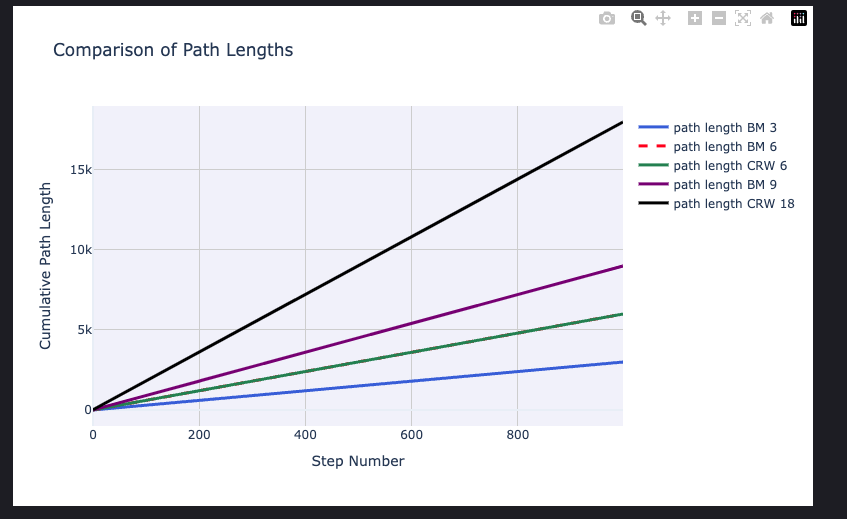

# Activity 2

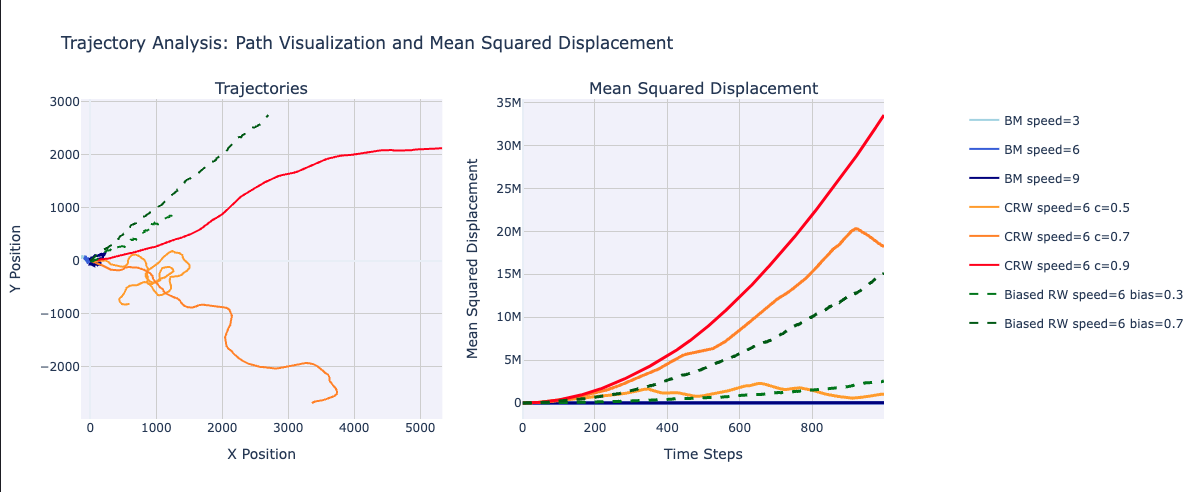
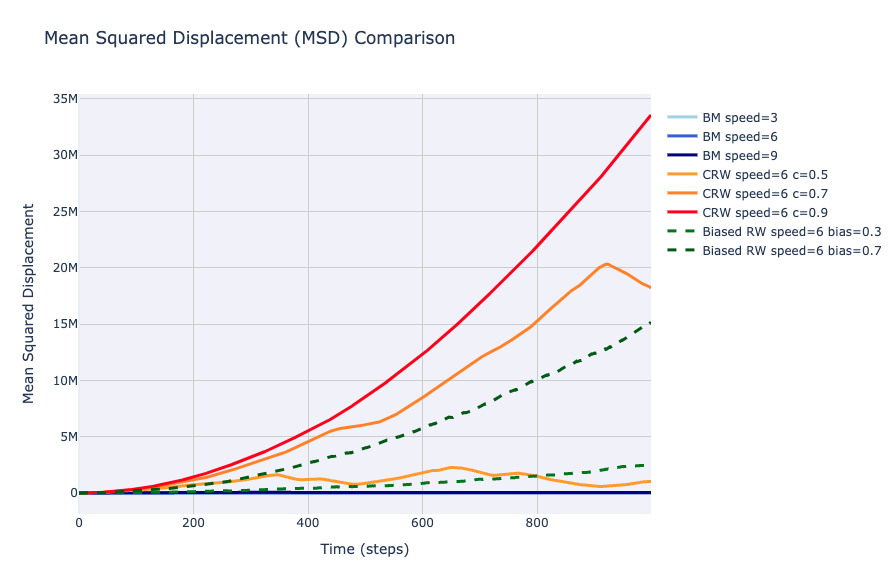
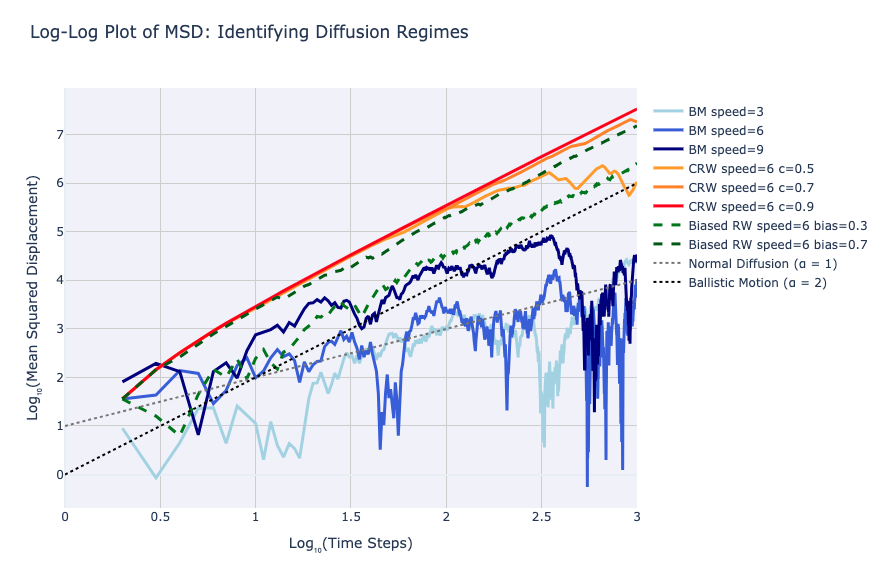

# Activity 3

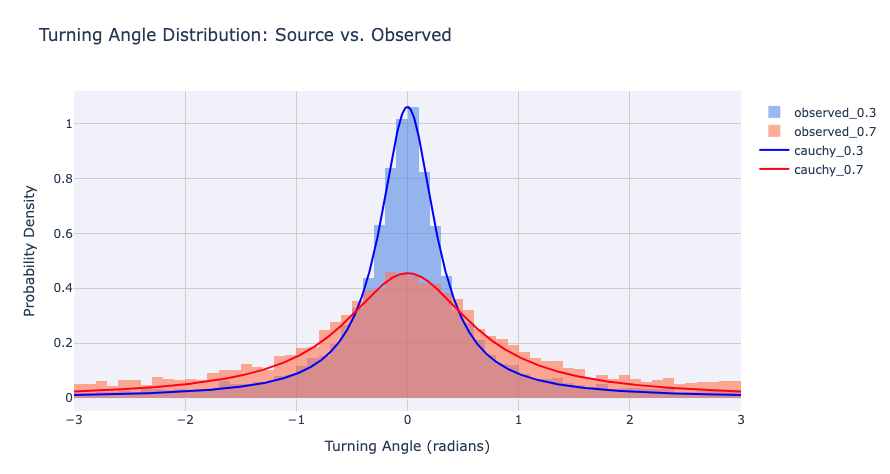
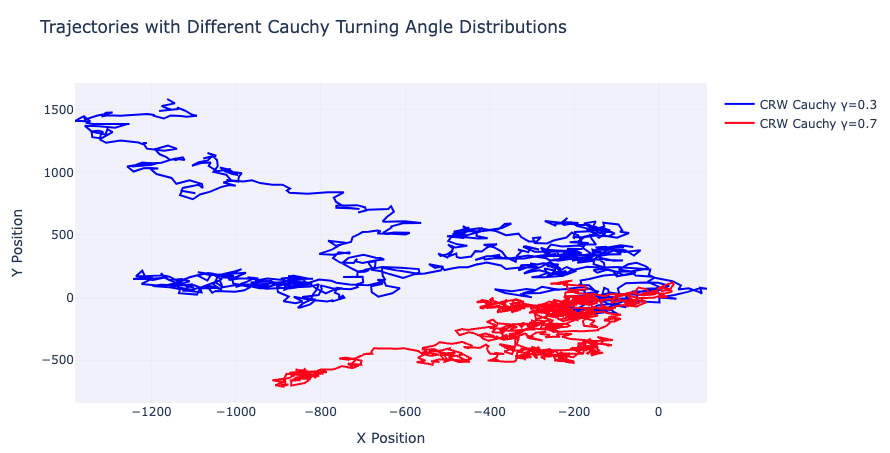

# Activity 4
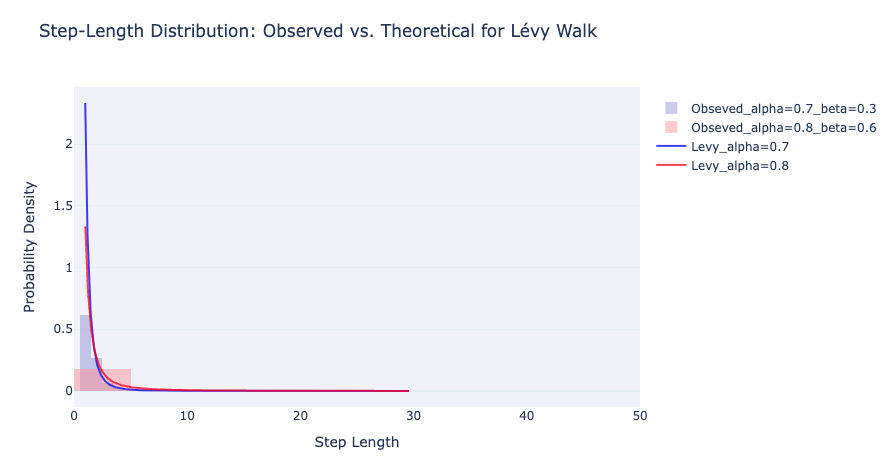
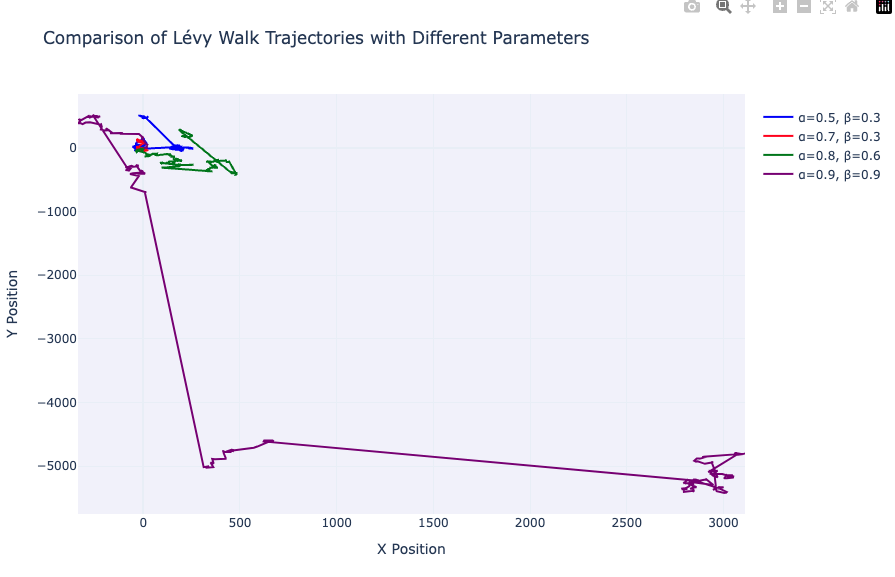